# Uncertainty analysis 

In [1]:
%load_ext autoreload

# Packages -----------------
import os
import sys
import shutil
import warnings
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy import constants
from matplotlib.path import Path

# Get notebook and parent dir
current_dir = os.path.dirname(os.path.abspath('__file__')) 
parent_dir = os.path.dirname(current_dir)

# Set path to pedophysics module 
pedophysics_code_path = os.path.join(parent_dir)
sys.path.insert(0, pedophysics_code_path)

import pedophysics
from pedophysics import predict, Soil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr
from scipy.optimize import minimize, differential_evolution
from IPython.display import clear_output
from utils.spatial_utils import utm_to_epsg, get_coincident
!pip install pymel
import pymel
from FDEM import Initialize
from utils.profile_utils import merge_layers, plot_profile, check_uniformity_and_interpolate

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from PyPDF2 import PdfMerger
from emagpy import Problem

# Electromagnetic induction data inversion package
from plots import *
from PM import *
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.options.future.infer_string = True

sys.path.insert(0,'../src/') # this add the emagpy/src directory to the PATH

## Pedophysical modelling

In [2]:
# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# User input
s_site = 'M'; # P = Proefhoeve; M = Middelkerke
# Define input datatype and source folder
em_intype = 'rec'   # 'rec' = rECa transect; 'lin' = LIN ECa transect; 
                    # 'survey' = rEC full survey

config = {}

config['instrument_code'] = 'Dualem-21HS' # instrument code

cal = 'calibrated' # 'non_calibrated', 'drift_calibrated'
instrument_code = '21HS' # 421S, '21HS'

# User input

datafolder = 'data' # data folder

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
        
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'

In [3]:
# Data import dry down experiment
dry_down = os.path.join(datafolder, f'Dry_down.csv')
dry_d = pd.read_csv(dry_down, sep=',', header=0)

cal_folder = os.path.join(datafolder, 'calibrated')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_calibrated_rECa.csv')
em_survey = pd.read_csv(em_survey, sep=',', header=0)
sampleprop = os.path.join(datafolder, f'{profile_prefix}_soil_analysis.csv')
samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)

em_sample_prop = get_coincident(em_survey, samples_analysis)
ds_c = em_sample_prop.copy()

inverted_data = False # Include inverted data or not

if inverted_data:
    inverted = os.path.join(datafolder, f'{profile_prefix}_inverted_samples_{instrument_code}c.csv')
    ds_inv = pd.read_csv(inverted, sep=',', header=0)
    print(ds_inv.head())

    inv_columns = ds_inv.columns[3:-1]
    ds_c[inv_columns] = np.nan

    for idc, c in enumerate(inv_columns):

        for i in range(len(ds_inv.x)):
            ds_c.loc[ds_c.code == i+1, c] = ds_inv.loc[i, c]

    def closest_ec(row):
        depth = row['depth']
        # Filter columns that start with 'EC_' but not 'EC_end'
        ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
        # Convert the part after 'EC_' to float and calculate the absolute difference with depth
        differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
        # Find the column name with the minimum difference
        closest_col = min(differences, key=differences.get)
        return row[closest_col]


    # Apply the function to each row
    ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

    #Obtain EC DC TC
    ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                        frequency_ec = 9e3,
                                                        bulk_ec = ds_c.bulk_ec_inv.values/1000))
    # Mean of input inverted EC DC TC values
    EC_mean = np.mean(ds_c['bulk_ec_dc_tc_inv'].values) 

# Deterministic modelling

In [4]:
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

ds_c['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds_c.bulk_ec_hp.values))

ds_c['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds_c.bulk_ec_hp, ds_c.temp)
ds_c['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values,
                                                    bulk_ec_dc = ds_c.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['water_ec_hp_t'] = WraithOr(ds_c.water_ec_hp, ds_c.temp)
ds_c['iperm_water_t'] = ds_c.water_ec_hp_t/(50e6*2*pi*epsilon_0)

# -------------------------------------------------------------------------------------

# DRY DOWN experiment
dry_d['P_top_EC'] = logsdon(50e6, dry_d.P_top_RP, dry_d.P_top_IP)
dry_d['P_bot_EC'] = logsdon(50e6, dry_d.P_bot_RP, dry_d.P_bot_IP)
dry_d['M_top_EC'] = logsdon(50e6, dry_d.M_top_RP, dry_d.M_top_IP)
dry_d['M_bot_EC'] = logsdon(50e6, dry_d.M_bot_RP, dry_d.M_bot_IP)

dry_d['P_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_top_EC.values,
                                          water = dry_d.P_top_W.values,
                                          temperature = dry_d.P_top_T.values+273.15))

dry_d['P_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_bot_EC.values,
                                          water = dry_d.P_bot_W.values,
                                          temperature = dry_d.P_bot_T.values+273.15))

dry_d['M_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_top_EC.values,
                                          water = dry_d.M_top_W.values,
                                          temperature = dry_d.M_top_T.values+273.15))

dry_d['M_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_bot_EC.values,
                                          water = dry_d.M_bot_W.values,
                                          temperature = dry_d.M_bot_T.values+273.15))

# DRY DOWN experiment
dry_d['P_top_EC'] = logsdon(50e6, dry_d.P_top_RP, dry_d.P_top_IP)
dry_d['P_bot_EC'] = logsdon(50e6, dry_d.P_bot_RP, dry_d.P_bot_IP)
dry_d['M_top_EC'] = logsdon(50e6, dry_d.M_top_RP, dry_d.M_top_IP)
dry_d['M_bot_EC'] = logsdon(50e6, dry_d.M_bot_RP, dry_d.M_bot_IP)

dry_d['P_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_top_EC.values,
                                          water = dry_d.P_top_W.values,
                                          temperature = dry_d.P_top_T.values+273.15))

dry_d['P_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.P_bot_EC.values,
                                          water = dry_d.P_bot_W.values,
                                          temperature = dry_d.P_bot_T.values+273.15))

dry_d['M_top_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_top_EC.values,
                                          water = dry_d.M_top_W.values,
                                          temperature = dry_d.M_top_T.values+273.15))

dry_d['M_bot_ECw'] = predict.WaterEC(Soil(bulk_ec_dc = dry_d.M_bot_EC.values,
                                          water = dry_d.M_bot_W.values,
                                          temperature = dry_d.M_bot_T.values+273.15))

if profile_prefix == 'proefhoeve':
    water_ec_10cm = dry_d.P_top_ECw.values[0]
    water_ec_50cm = dry_d.P_bot_ECw.values[0]
    water_ec_mean = (water_ec_10cm + water_ec_50cm)/2

elif profile_prefix == 'middelkerke':
    water_ec_10cm = dry_d.M_top_ECw.values[0]
    water_ec_50cm = dry_d.M_bot_ECw.values[0]
    water_ec_mean = (water_ec_10cm + water_ec_50cm)/2

###################

# -------------------------------------------------------------------------------------

clay_50cm = np.mean(ds_c.clay[ds_c['depth']==50])
clay_10cm = np.mean(ds_c.clay[ds_c['depth']==10])
bd_50cm = np.mean(ds_c.bd[ds_c['depth']==50])
bd_10cm = np.mean(ds_c.bd[ds_c['depth']==10])
water_ec_hp_50cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==50])
water_ec_hp_10cm = np.mean(ds_c.water_ec_hp[ds_c['depth']==10])
water_ec_hp_50cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==50])
water_ec_hp_10cm_t = np.mean(ds_c.water_ec_hp_t[ds_c['depth']==10])
clay_mean = np.mean(ds_c.clay)
bd_mean = np.mean(ds_c.bd)
water_ec_hp_mean = np.mean(ds_c.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds_c.water_ec_hp_t)
temp_50cm = np.mean(ds_c.temp[ds_c['depth']==50])
temp_10cm = np.mean(ds_c.temp[ds_c['depth']==10])
temp_mean = np.mean(ds_c.temp)
vwc_50cm = np.mean(ds_c.vwc[ds_c['depth']==50])
vwc_10cm = np.mean(ds_c.vwc[ds_c['depth']==10])
vwc_mean = np.mean(ds_c.vwc) # 0.289 Proef

f_ec = 9000
t_conv = 273.15
t_mean_conv = temp_mean+t_conv # 297.28 Proef

# Mean of observed water values
VWC_mean = np.mean(ds_c['vwc'].values) # 0.2891 Proef

In [5]:
# Predicted water based on mean input inverted EC DC TC values
water_upper = 0.05
water_default = 0
water_lower = -0.05
water_upper_p = 5
water_default_p = 0
water_lower_p = -5

def EC_diff(EC, vwc_diff):

    VWC_mean_pred = predict.Water(Soil(
                                        bulk_ec = EC,  
                                        frequency_ec=f_ec,
                                        clay = clay_mean,
                                        bulk_density = bd_mean,
                                        water_ec = water_ec_mean,
                                        temperature = t_mean_conv
                                    ))[0] 

    return ((VWC_mean_pred - VWC_mean) - vwc_diff)**2

# EC expected
EC_5 = minimize(EC_diff, 0.01, args=(water_upper), bounds= [(0, 1)], method='Nelder-Mead')
EC_upper = EC_5.x[0]

EC_0 = minimize(EC_diff, 0.01, args=(water_default), bounds= [(0, 1)], method='Nelder-Mead')
EC_00 = EC_0.x[0]

EC_n5 = minimize(EC_diff, 0.01, args=(water_lower), bounds= [(0, 1)], method='Nelder-Mead')
EC_lower = EC_n5.x[0]

print(EC_upper, EC_lower, EC_00)

# Difference percentual
EC_upper_p = 100*(EC_upper - EC_00)/EC_00
EC_lower_p = 100*(EC_00 - EC_lower)/EC_00
print(EC_upper_p, EC_lower_p)

sens_pedm_upper = water_upper_p/EC_upper_p
sens_pedm_lower = water_lower_p/EC_lower_p
print(sens_pedm_upper, sens_pedm_lower)

0.08350000000000013 0.05825000000000008 0.07050000000000009
18.439716312056767 17.375886524822686
0.27115384615384575 -0.28775510204081645


In [6]:
temp_dir = 'temp_emp_04' 
infile_name = 'infile_s04.csv'
os.makedirs(temp_dir, exist_ok=True)
temp_file = os.path.join(temp_dir,infile_name)

filename = f"{now}_{emfile_prefix}_parameters_04.json"
filepath = os.path.join(temp_dir,filename)
file = open(filepath, 'w')

file.write('\t"EC_00":"{}",'.format(EC_00) + '\n')
file.write('\t"EC_upper_p":"{}",'.format(EC_upper_p) + '\n')
file.write('\t"EC_lower_p":"{}",'.format(EC_lower_p) + '\n')

file.write('\t"sens_pedm_upper":"{}",'.format(sens_pedm_upper) + '\n')
file.write('\t"sens_pedm_lower":"{}",'.format(sens_pedm_lower) + '\n')

43

# Inversion: configure  input

In [7]:
# Sensor settings
config['instrument_code'] = 'Dualem-21HS' # instrument code
config['instrument_height'] = 0.165     # instrument height
config['instrument_orientation'] = 'HCP'    # instrument orientation

# Remove coils for inversion?
config['remove_coil'] = True    # set to True if you want to remove coils in the inversion process
config['coil_n'] = [4,5]    # indexes of coils to remove (cf. emagpy indexing)
                            # for Proefhoeve, coils 0 (HCP05) and 1 (PRP06) are best
                            # removed, for Middelkerke coils 4 (HCP4.0) and 5 (PRP4.1)

# Inversion parameters
config['fs_emp'] = 'FSeq' #'CS', 'FSlin' or 'FSeq'
config['opt_method'] = 'L-BFGS-B'  # mMinimize = ['L-BFGS-B','TNC','CG','Nelder-Mead'] --> https://docs.scipy.org/doc/scipy/reference/optimize.html 
                                # mMCMC = ['ROPE','DREAM', 'MCMC'] # ??? 'SCEUA' ??? --> https://spotpy.readthedocs.io/en/latest/ 
                                # mOther = ['ANN','Gauss-Newton','GPS'] (ANN requires tensorflow)
config['constrain']=True
config['regularization'] = 'l2'
config['alpha'] = 0.07

# Reference profile for starting model (conductivity values)
config['start_avg'] = False     # take average of input resistivity profiles per layer as starting model
                                # if false, reference profile is taken as starting model

# Define the interfaces depths between layers for starting model and inversion
#           (number of layers = len(config['interface'])+1)
config['n_int'] = True # if True custom interfaces are defined (via config['interface']), 
                        # otherwise reference profile interfaces are used

config['interface'] = [0.3, 
                       0.6, 
                       1.0,
                       2.0
                        ] # depths to custom model interfaces
# Inversion constraining

config['custom_bounds'] = True
config['bounds'] = [(10, 55), (20, 120), (50, 335), (50, 250), (10, 50)]

# remove profiles at transect edges
config['n_omit'] =  10 # number of profiles to exclude from the start
                       # and end of the ERT transect (none = 0) for the inversion
                       # a total of 60 profiles is available, for middelkerke
                       # 120 profiles are available 

if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']

if config['n_int'] == False and config['custom_bounds']:
    print('Check if bounds and number of interfaces match')

# Geographic operations (if needed)
c_transform = False
c_utmzone = '31N'
c_target_cs = 'EPSG:31370'

# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

## Load data

In [8]:
# ---------------------------------------------------------------------------- #
# ---------------------------------------------------------------------------- #

if s_site == 'P':
    profile_prefix = 'proefhoeve'
    if config['instrument_code'] == 'Dualem-21HS':
        emfile_prefix = 'proefhoeve_21HS'
    else: 
        emfile_prefix = 'proefhoeve_421S'
else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'
    # check if correct instrument (only 421S data available for Middelkerke)
    if config['instrument_code'] == 'Dualem-21HS':
        config['instrument_code'] = 'Dualem-421S'

inv_folder = os.path.join(datafolder, 'inverted')
os.makedirs(inv_folder, exist_ok=True) 
cal_folder = os.path.join(datafolder, 'calibrated')
ert_file = os.path.join(datafolder, f'{profile_prefix}-profiles.csv')
em_rec = os.path.join(cal_folder, f'{emfile_prefix}_transect_calibrated_rECa.csv')
em_lin = os.path.join(cal_folder,f'{emfile_prefix}_transect_calibrated_LIN.csv')
em_survey = os.path.join(cal_folder, f'{emfile_prefix}_calibrated_rECa.csv')
samplocs = os.path.join(datafolder, f'{profile_prefix}_samps.csv')

if em_intype == 'rec':
    infile = em_rec
elif em_intype == 'survey':
    infile = em_survey
else:
    infile = em_lin

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                    instrument_orientation=config['instrument_orientation']
                                    )

# Column names for emapgy input
emp_21HS = [f"HCP0.5f9000{config['instrument_height']}", 'PRP0.6f9000h0.165', 'HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165',
            'HCP0.5f9000h0.165_inph', 'PRP0.6f9000h0.165_inph', 'HCP1.0f9000h0.165_inph',
            'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph'
            ]

emp_421S = ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165',	'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165', 'HCP4.0f9000h0.165', 'PRP4.1f9000h0.165', 
            'HCP1.0f9000h0.165_inph', 'PRP1.1f9000h0.165_inph', 'HCP2.0f9000h0.165_inph', 'PRP2.1f9000h0.165_inph',
            'HCP4.0f9000h0.165_inph', 'PRP4.1f9000h0.165_inph',
            ]

if config['opt_method'] == 'Gauss-Newton':
    config['regularization'] = 'l2'

# Datetime for filename
now = (datetime.datetime.now())
now = now.strftime("%y%m%d_%H%M")

# 1.0 Data import and structuring into dataframe
ert_p = pd.read_csv(ert_file, sep=',', header=0)
em_rec = pd.read_csv(em_rec, sep=',', header=0)
em_lin = pd.read_csv(em_lin, sep=',', header=0)
em_survey = pd.read_csv(em_survey, sep=',', header=0)
samples = pd.read_csv(samplocs, sep=',', header=0)


if c_transform:
    # Create a new filename with the target EPSG code
    em_rec = utm_to_epsg(em_rec, c_utmzone, target_epsg=c_target_cs)
    em_lin = utm_to_epsg(em_lin, c_utmzone, target_epsg=c_target_cs)
    em_survey = utm_to_epsg(em_survey, c_utmzone, target_epsg=c_target_cs)

instrument = Initialize.Instrument(config['instrument_code'],
                                    instrument_height=config['instrument_height'],
                                        instrument_orientation=config['instrument_orientation']
                                        )

em_samples = get_coincident(em_survey,samples)

# ---------------------------------------------------------------------------- #
# Get ERT profiles
# ---------------- #
# Group the data by profile ID for efficient access to each profile
profiles = ert_p.groupby('ID')

# Exclude the first and last n_omit profiles
unique_ids = ert_p['ID'].unique()

if config['n_omit'] == 0:
    ert_final = ert_p.copy()
else:
    if config['n_omit']*2 >= len(unique_ids):
        warnings.warn('!!! You removed all profiles !!! Change value for config[n_omit]')
        raise KeyboardInterrupt
    else:
        selected_ids = unique_ids[config['n_omit']:-config['n_omit']]
        ert_p = ert_p.loc[ert_p['ID'].isin(selected_ids)]
        ert_final = ert_p.copy()

dataset_name = 'Resistivity(ohm.m)'  # The variable of interest

# convert resistivity to conductivity and modify column names

ert_final[dataset_name] = (1/ert_final[dataset_name])
dc_corr = ert_final.copy()
dc_corr[dataset_name] = predict.BulkEC(Soil(
                                                frequency_ec = 9000,
                                                bulk_ec_dc = dc_corr[dataset_name].values
                                                ))

ert_final.loc[:, dataset_name] = ert_final[dataset_name]*1000
dc_corr.loc[:,dataset_name] = dc_corr[dataset_name]*1000
ert_final = ert_final.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})
dc_corr = dc_corr.rename(columns={"Resistivity(ohm.m)": "EC(mS/m)"})

# ------------------------------------------------------------------------------

# Columns containing the resistivity data
data_column = ['EC(mS/m)']
# Assuming ert_final is your DataFrame with profile data
all_profiles_df, uniform_intervals = check_uniformity_and_interpolate(
    dc_corr, 'ID', 'z', *data_column
)

dataset_name = 'EC(mS/m)'  # The variable of interest

<Figure size 1000x800 with 0 Axes>

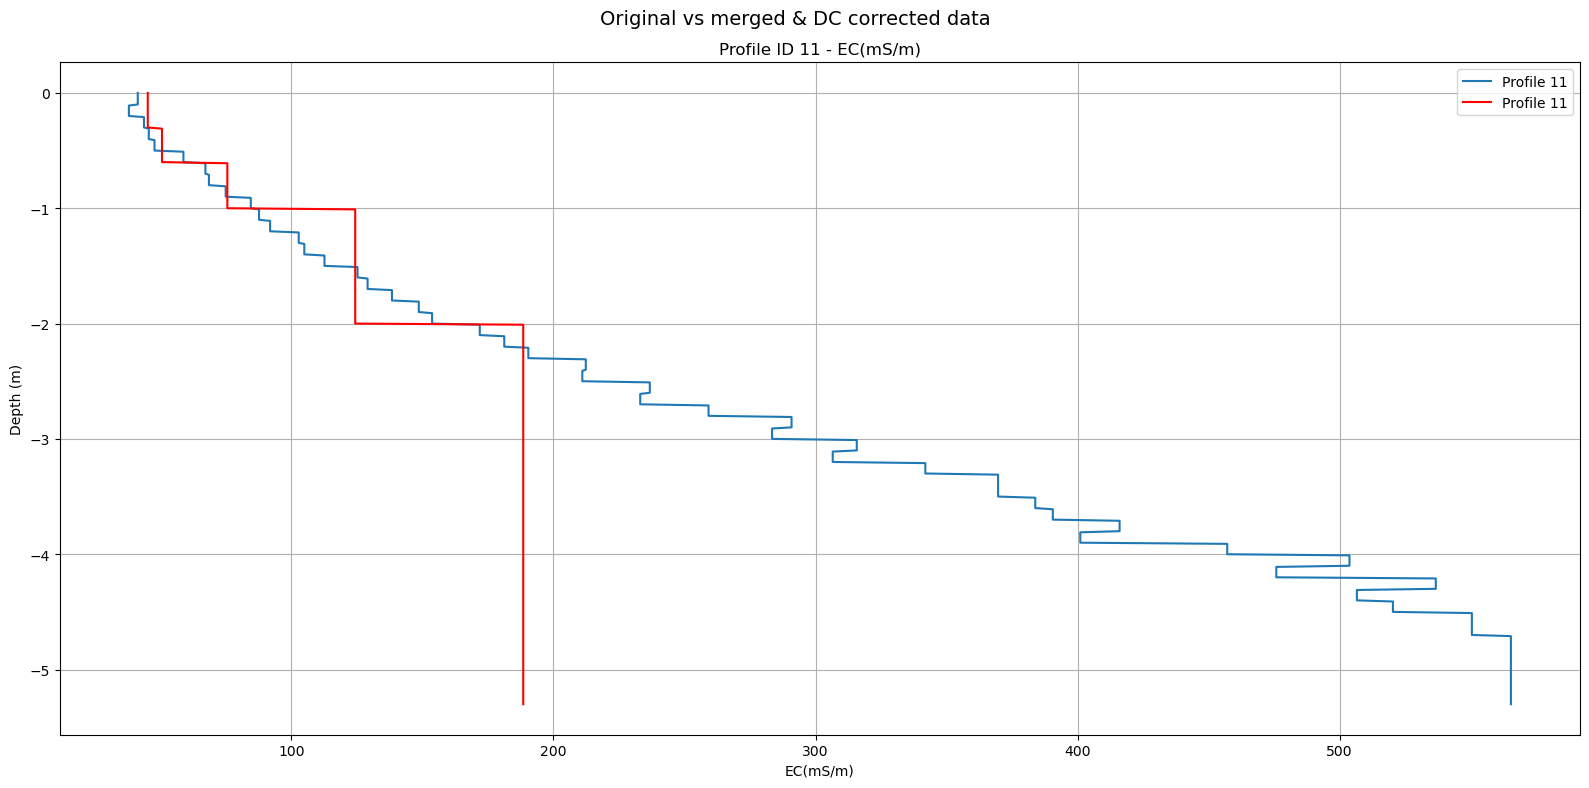

In [9]:
config['reference_profile'] = 11

if config['reference_profile'] not in all_profiles_df['ID'].unique():
    warnings.warn("Warning: the reference profile ID does not exist. Provide correct profile ID.")
    raise KeyboardInterrupt
else:
    profile_id = config['reference_profile']

# Create new layer configuration for prior model based on ERT data
if config['n_int']:
    new_int = config['interface']
    merged_df = merge_layers(all_profiles_df, new_int,'EC(mS/m)')
else:
    merged_df = all_profiles_df
comparedf = merged_df.copy()

# Plot original and (merged and) DC corrected reference profile
if config['n_int']:
    plot_title = 'Original vs merged & DC corrected data'
    first_in = .1
else: 
    plot_title = 'Original vs DC corrected data'
    first_in = .0
ert_eval = ert_final.copy()
ert_eval['z'] = ert_eval['z'].values + first_in

plot_profile(ert_eval, profile_id, dataset_name, compare=True, compare_df = comparedf, compare_name = 'EC(mS/m)', block=True, plot_title=plot_title)

# Get prior model info
def generate_forward_model_inputs(df, profile_id_col, depth_col, res_col):
    models = {}  # Dictionary to store models by profile ID

    for profile_id, group in df.groupby(profile_id_col):
        # Assuming uniform interval after previous interpolation
        uniform_interval = abs(group[depth_col].diff().iloc[1])
        #print(uniform_interval)
        num_layers = len(group[res_col])
                # Thicknesses are the intervals between depths, except for the last value which does not define a new layer
        thick = np.full(num_layers - 1, uniform_interval)
        thick[0] = 2 * thick[0]
        # Conductivity is the inverse of resistivity
        con = group[res_col].values/1000
        # Permittivity is the epsilon_0 for all layers
        perm = np.full(num_layers, constants.epsilon_0)
        sus = np.zeros(num_layers)
        # Create model instance
        M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])
        
        # Store the model instance in the dictionary with the profile ID as the key
        models[profile_id] = M
    return models

models = generate_forward_model_inputs(merged_df, 'ID', 'z', 'EC(mS/m)')

conductivities [188.47   124.346   75.5445  50.615   45.1825]


C:\Users\mendo\AppData\Local\Temp\ipykernel_6344\787312582.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])


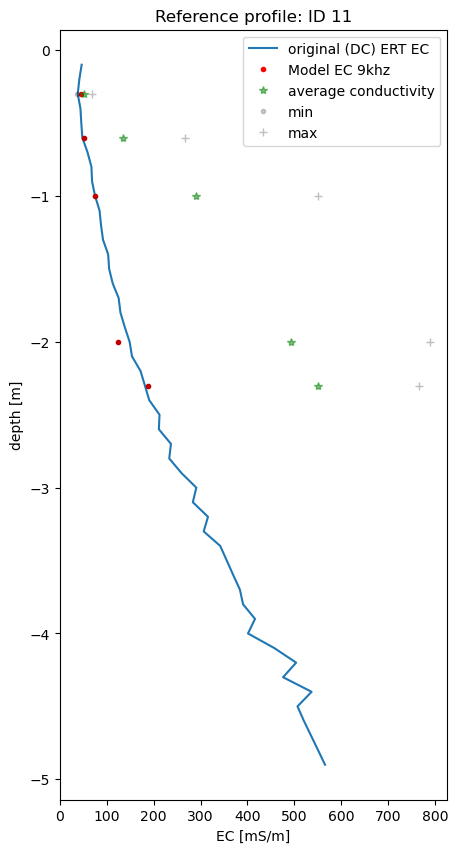

In [10]:
# 
# -------------------------------------------------------------------- #

# 
profile_data = merged_df[merged_df['ID'] == profile_id].copy()
res_col = 'EC(mS/m)'
depth = 'z'
max_ert_depth = ert_final['z'].abs().max()

# 
# ------------------------------------------------------------------------------

# A. Test run on the reference profile (config['reference_profile'])
#       and plot the results

if not config['n_int']:
    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)
    if first_lay == 0:
        profile_data[depth]=profile_data[depth] +second_lay
    else:
        profile_data[depth]=profile_data[depth] +first_lay
    thick = -profile_data[depth].iloc[1:].values
    #thick = -profile_data[depth].values
else:
    thick = -profile_data[depth].values

con = profile_data[res_col].values/1000
ref_len = len(con)
num_layers = len(con)
perm = np.full(num_layers, constants.epsilon_0)
sus = np.zeros(num_layers)

# # Create model instance
M = Initialize.Model(thick, sus[::-1], con[::-1], perm[::-1])

# ----------------------------------------------------------------------

dataset_name = 'EC(mS/m)'
layers_interfaces = np.cumsum(models[profile_id].thick)
layers_interfaces = np.insert(layers_interfaces, 0, 0)
profile_data = ert_final[ert_final['ID'] == profile_id]

fig, axr = plt.subplots(figsize=(5, 10))
axr.set_xlabel('EC [mS/m]')
axr.set_ylabel('depth [m]')
axr.plot((profile_data[dataset_name]),profile_data['z'], label='original (DC) ERT EC',)
if not config['n_int']: 
    axr.plot(con[:-1]*1000,-thick, '.', label='Model EC 9khz',color = 'red')
else:
    axr.plot(con*1000,-thick, '.', label='Model EC 9khz',color = 'red')
axr.set_title(f'Reference profile: ID {profile_id}')

conductivities = con*1000
print('conductivities', conductivities)

ec_cols_ref = []
if 'end' in config['interface']:
    config['interface'].remove('end')
# Get conductivity stats for bounds
if config['n_int']:
    if 'end' in ec_cols_ref:
        ec_cols_ref.remove('end')
    ec_cols_ref = config['interface']
    ec_cols_ref.append('end')
    mod_layers = thick[1:]
else:
    if len(conductivities) == len(thick):
        mod_layers = thick[1:]
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    elif len(conductivities) == (len(thick)+1):
        mod_layers = thick
        print(f"length modlayers = {len(mod_layers)} with {len(conductivities)} conductivities")
    else:
        raise ValueError(f"Check length of conductivities ({len(conductivities)}) and layers ({len(thick)}) arrays!!")
    
    ec_cols_ref = np.round(layers_interfaces,decimals=1).tolist()
ec_df = pd.DataFrame(columns=ec_cols_ref)

# 
for i in merged_df['ID'].unique(): 
    profile_data = merged_df[merged_df['ID'] == i].copy()
    if not config['n_int']:
        if abs(profile_data.iloc[0]['z']) > max((list(map(abs, ec_cols_ref)))):
            #print(f'removed {profile_data.iloc[0]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[0].name)
        elif abs(profile_data.iloc[-1]['z']) < 0.1:
            #print(f'removed {profile_data.iloc[-1]["z"]}')
            profile_data = profile_data.drop(profile_data.iloc[-1].name)
    res_col = 'EC(mS/m)'
    depth = 'z' 
    con_m = profile_data[res_col].values
    layers_interfaces = np.cumsum(models[i].thick)
    layers_interfaces = np.insert(layers_interfaces, 0, 0)
    num_layers = len(con)
    perm = np.full(num_layers, constants.epsilon_0)
    sus = np.zeros(num_layers)

    first_lay = profile_data[depth].iloc[-1].round(decimals=1)
    second_lay = profile_data[depth].iloc[-2].round(decimals=1)

    if not config['n_int']:
        first_lay = profile_data[depth].iloc[-1].round(decimals=1)
        second_lay = profile_data[depth].iloc[-2].round(decimals=1)
        if first_lay == 0:
            profile_data[depth]=profile_data[depth] +second_lay
        else:
            profile_data[depth]=profile_data[depth] +first_lay
        thick = -profile_data[depth].iloc[1:].values
    else:
        thick = -profile_data[depth].values

    ec_df = pd.concat([ec_df, pd.DataFrame([np.flip(con_m)], columns=ec_cols_ref)])

ec_df.reset_index(drop=True, inplace=True)

ec_stats = ec_df.describe().loc[['min', 'max', 'std', '50%', 'mean']]
ec_stats.rename(index={'50%': 'median'}, inplace=True)
ec_stats.loc['min_sd'] = ec_stats.loc['min'] - 2 * ec_stats.loc['std']
ec_stats.loc['max_sd'] = ec_stats.loc['max'] + 2 * ec_stats.loc['std']

position = -thick


# define parameters for inversion starting model
# --------------------------------------------- #

if not config['n_int']:
    minstat = np.flipud(ec_stats.loc['min'].values[1:])
    maxstat = np.flipud(ec_stats.loc['max'].values[1:])
    start_mod = ec_stats.loc['mean'].values[1:]
    boundcols = ec_cols_ref[:-1]
else:
    minstat = np.flipud(ec_stats.loc['min'].values)
    maxstat = np.flipud(ec_stats.loc['max'].values)
    start_mod = ec_stats.loc['mean'].values

axr.plot(np.flipud(start_mod),position, 
            '*', 
            label='average conductivity',
            color = 'green',
            alpha = 0.5)
axr.plot(minstat,position, 
            '.', 
            label='min',
            color = 'black',
            alpha = 0.2)
axr.plot(maxstat,position, 
            '+', 
            label='max',
            color = 'black',
            alpha = 0.25)

axr.legend()
if config['constrain']:
    if config['custom_bounds']:
        bounds = config['bounds']
    else:
        bounds = []
        for i, name in enumerate(ec_cols_ref):
            if ec_stats.loc['min_sd'][name] > 0:
                min = ec_stats.loc['min_sd'][name]
            elif ec_stats.loc['min'][name] > 0:
                min = ec_stats.loc['min'][name]
            else:
                min = 10
            max = ec_stats.loc['max_sd'][name]
            min_max = tuple([min,max])
            bounds.append(min_max)
        bounds = np.round(bounds, decimals=0)
        if not config['n_int'] and not config['custom_bounds']:
            bounds = bounds[1:]
        print(f'autobounds = {bounds}')

In [11]:
# Perform inversion on sampling locations (to be used in pedophysical modelling)

if 'code' in em_samples.columns:
    em_samples = em_samples.rename(columns={'code': 'ID'})

i = instrument.niter
n = 4
em_samples.columns.values[n:n+i]

if config['instrument_code'] == 'Dualem-21HS':
    new_columns = emp_21HS
else:
    new_columns = emp_421S

if len(new_columns) != i:
    raise ValueError("The length of new_columns must be equal to the number of columns to rename")
else:
    em_samples.columns.values[n:n+i] = new_columns

em_samples.to_csv(temp_file)

# transect inversion settings

s_rec = Problem()
s_rec.createSurvey(temp_file)
#t_rec.rollingMean(window=12)

s_rec.setInit(
    depths0=np.flipud(mod_layers),
    conds0=conductivities
    )

if config['remove_coil']:
    if type(config['coil_n']) == list:
        config['coil_n'] = sorted(config['coil_n'])
        for i in enumerate(config['coil_n']):
            r_coil = s_rec.coils[(config['coil_n'][i[0]]-i[0])]
            # print(f'removing {r_coil}')
            s_rec.removeCoil(config['coil_n'][i[0]]-i[0])
    else:
        s_rec.removeCoil(config['coil_n'])

print(f'Data used for inversion: {s_rec.coils}')

Data used for inversion: ['HCP1.0f9000h0.165', 'PRP1.1f9000h0.165', 'HCP2.0f9000h0.165', 'PRP2.1f9000h0.165']


Inversion using FSeq with L-BFGS-B, reg=l2, alpha=0.07
15/15 inverted

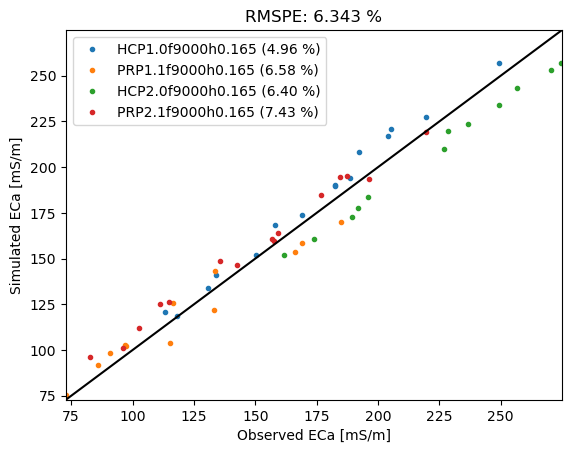

In [12]:
# invert using ROPE solver (RObust Parameter Estimation)
warnings.filterwarnings('ignore')
opt_meth = config['opt_method']
inv_meth = config['fs_emp']
reg_meth = config['regularization']
alph_param = config['alpha']
if opt_meth in ['MCMC', 'ROPE']:
    if config['constrain']:
        
        print(f'Constrained inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
                regularization=reg_meth, alpha=alph_param, 
                bnds=bounds
                )

    else:
        print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
        s_rec.invert(forwardModel=config['fs_emp'], method=opt_meth, 
        regularization=reg_meth, alpha=alph_param, njobs=-1
        )

else:
    print(f'Inversion using {inv_meth} with {opt_meth}, reg={reg_meth}, alpha={alph_param}')
    s_rec.invert(forwardModel='FSeq', method='Gauss-Newton', alpha=alph_param,regularization=reg_meth)
s_rec.showOne2one()

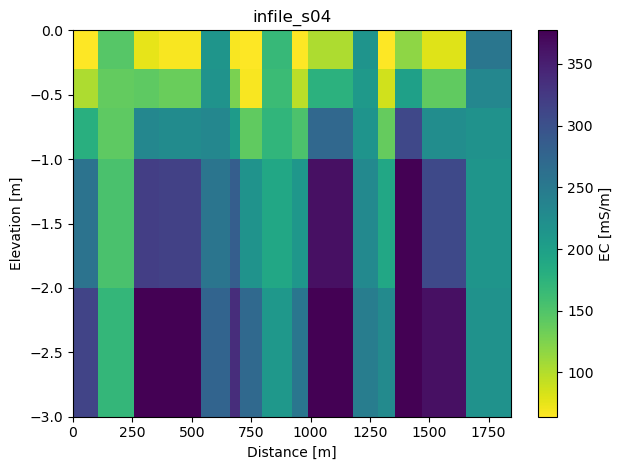

In [13]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------
csv_filename = f'{now}_{emfile_prefix}_inverted_samples_{opt_meth}_04.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
s_rec.showResults(dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = s_rec.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[s_rec.surveys[0].df[['x', 'y']].values, s_rec.models[0]]

# Creating the final dataframe with the desired column names
ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
ds_inv['pos'] = em_samples['ID'].to_numpy()
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
outfile_transect = os.path.join(inv_folder, csv_filename)
ds_inv.to_csv(outfile_transect)

In [14]:
inv_columns = ds_inv.columns[3:-1]
ds_c[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(ds_inv.x)):
        ds_c.loc[ds_c.code == i+1, c] = ds_inv.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds_c['bulk_ec_inv'] = ds_c.apply(closest_ec, axis=1)

#Obtain EC DC TC
ds_c['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds_c.temp.values+273.15,
                                                    frequency_ec = 9e3,
                                                    bulk_ec = ds_c.bulk_ec_inv.values/1000))
# Mean of input inverted EC DC TC values
EC_mean = np.mean(ds_c['bulk_ec_dc_tc_inv'].values) 
print('EC_mean', EC_mean)

#### Uncertainty inversion parameters
EC = 0.06980570031133289

### ROPE uncertainty
inv_results = [0.075, 0.069, 0.073, 0.0687, 0.0695, 0.0719, 0.0745, 0.0709, 0.0644, 0.0708]

ROPE_inv_upper_p = 100*(-EC + np.max(inv_results))/(np.max(inv_results))
ROPE_inv_lower_p = 100*(-EC + np.min(inv_results))/(np.min(inv_results))
print('ROPE_inv_upper_p, ROPE_inv_lower_p', ROPE_inv_upper_p, ROPE_inv_lower_p)

### Alpha uncertainty
Alpha_upper = np.inf
Alpha_lower = 0.001
Alpha = 0.07

Alpha_upper_p = 100*(Alpha_upper - Alpha)/Alpha
Alpha_lower_p = 100*(-Alpha + Alpha_lower)/Alpha
print('Alpha_upper_p, Alpha_lower_p', Alpha_upper_p, Alpha_lower_p)

sens_alpha_upper = EC_upper_p/Alpha_upper_p
sens_alpha_lower = EC_lower_p/Alpha_lower_p
print('sens_alpha_upper, sens_alpha_lower', sens_alpha_upper, sens_alpha_lower)

EC_mean 0.13781578639168793
ROPE_inv_upper_p, ROPE_inv_lower_p 6.9257329182228125 -8.393944582815045
Alpha_upper_p, Alpha_lower_p inf -98.57142857142857
sens_alpha_upper, sens_alpha_lower 0.0 -0.1762771096721142


In [15]:
file.write('\t"EC_mean":"{}",'.format(EC_mean) + '\n')
file.write('\t"ROPE_inv_upper_p":"{}",'.format(ROPE_inv_upper_p) + '\n')
file.write('\t"ROPE_inv_lower_p":"{}",'.format(ROPE_inv_lower_p) + '\n')

file.write('\t"input file + path": "{}",'.format(infile) + '\n\n')
file.write('\t"instrument": "{}",'.format(config['instrument_code'] ) + '\n')
file.write('\t"instrument mode": "{}",'.format(config['instrument_orientation']) + '\n')
file.write('\t"instrument height (m)": {:.3f},'.format(config['instrument_height']) + '\n')

if config['remove_coil']:
    rem_coils = instrument.cc_names[config['coil_n']]
    file.write('\t"configurations not used in inversion": "{}",'.format(rem_coils) + '\n\n')

file.write('\t"forward model": "{}",'.format(config['fs_emp']) + '\n')
file.write('\t"optimisation method":"{}",'.format(config['opt_method']) + '\n')
file.write('\t"regularisation": "{}",'.format(config['regularization']) + '\n')
file.write('\t"alpha parameter": "{}",'.format(alph_param) + '\n\n')
file.write('\t"reference EC profile":"{}",'.format(config['reference_profile']) + '\n')

if config['constrain']:
    file.write('\t "constrained inversion":' + '\n')
    if config['n_int']:
        file.write('\t"custom interface boundaries": "{}"\n'.format(config['interface']) + '\n')
    if config['custom_bounds']:
        file.write('\t"custom inversion constraints (bnds)": "{}" \n'.format(config['bounds']) + '\n')
    else:
        file.write('\t"automated inversion constraints (bnds)": "{}"\n'.format(bounds) + '\n')

file.close()